% put the references in 
% test the code

# Time Evolution

In this segment of the tutorial, we delve into some time evolution techniques for MPS. In particular we will focus on the [TDVP](TDVP_header) and [Time Evolution MPO](TMPO_header) methods. Another method (i)[TEBD](tebd) has already been explained in an earlier section. Following this we briefly explain how [imaginary time evolution](Imag_header) can be used to find ground states and how [thermal density matrices](FinTemp_header) can be simulated using MPS.
At the end of this section we offer some basic [code examples](code_header).

In the case of quantum many body systems time evolution amounts to solving the time dependent Schrodinger equation

```{math}
:label: Schrodinger
i \frac{\partial}{\partial t} \ket{\Psi(t)}= \hat{H}\ket{\Psi(t)}
```

for a given Hamiltonian $\hat{H}$ with initial condition $\ket{\Psi_0}=\ket{\Psi(t_0)}$. For a time independent Hamiltonian the solution is given by 

```{math}
\ket{\Psi(t)} = U(t)\ket{\Psi_0} = \exp(-it\hat{H})\ket{\Psi_0}
```

By approximating the time evolution operator $U$ in the Tensor Network language, we can also study real-time dynamics.

```{note}
One should keep in mind that time evolution in general will increase the entanglement of the state so that in practice time evolution can only be done with Tensor Networks for relatively modest times. For example in case of a quench the entanglement for 1D systems grows as $S \sim t$ , (see {cite}`Calabrese_2005`) so that the bond dimension $D \sim \exp(at)$ in order to accurately follow the dynamics.
```

```{contents} Contents
:depth: 3
```

(TDVP_header)=
## TDVP

The Time-Dependent Variational Principle is an old concept, originaly developed by Dirac and Frenkel in the 1930's. The idea is to solve the schrodinger equation by minimizing
```{math}
\|i \frac{\partial}{\partial t} \ket{\Psi(t)}- \hat{H}\ket{\Psi(t)}\|^2
```
In the case of MPS, we can parametrize the state $\ket{\Psi(t)}$ by a set of time dependent matrices $\{A_1(t),A_2(t),\dots A_N(t)\}$ (where N is the system size for finiteMPS or the size of the unit cell for infinite MPS). In other words the state $\ket{\Psi(t)}$ lives in a manifold determined by these matrices, the MPS-manifold. Geometrically the solution of the minimization problem is given by the projection of the RHS of the schrodinger equation onto the MPS manifold 
```{math}
:label: TDVPeq
\frac{d}{dt} \ket{\Psi(A)} = -i \hat{P}_{T\ket{\Psi(A)}} \hat{H}\ket{\Psi(A)}
```
where $\hat{P}_{T\ket{\Psi(A)}}$ is the operator that projects the state onto the tangent space. As a consequence the time-evolving state will never leave the MPS manifold and parametrization in terms of $A(t)$ makes sense. One can in principle work out the above equation on the level of the $A$ matrices and try to solve the above equation. This gives a complicated set of (non-linear) equations that can be solved by one's favourite finite difference scheme, but requires the inversion of matrices with small singular values (and thus numerical instabilities) {cite}`haegeman2011time`, {cite}`HaegemanTDVP`. Instead, it turns out that a natural and inversion free way of solving this equation is possible if we use the gauge freedom of MPS.

For a finite MPS, one can show that in the mixed gauge the action of the projection operator onto $\hat{H}\ket{\Psi(A)}$ is given by {cite}`vanderstraeten2019tangentspace`
```{image} /_static/figures/timeev/TDVPProjector.png
:name: TDVPProjector
:align: center
```
The projector action consists of two sums, one where each term acts on the $A_C$ on site $n$ and the other on the bond tensor $C$ to the right of it. As a result {eq}`TDVPeq` now resembles an ODE of the form
```{math}
:label: SplittingODE
\frac{d}{dt} Y = A(Y) + B(Y)
```
This type of ODE can be solved by a splitting method {cite}`Lubich_2015` i.e. we solve $\frac{d}{dt} Y = A(Y)$ and $\frac{d}{dt} Y = B(Y)$ seperately and then combine the two results to obtain an approximate solution to {eq}`SplittingODE`. Applying this idea to {eq}`TDVPeq` we thus need to solve equations of the form
```{math}
\frac{d}{dt} \ket{\Psi(A)} = -i \hat{H}_{\text{eff}}^{A_C}[ A_C(n)]
```
and 
```{math}
\frac{d}{dt} \ket{\Psi(A)}= i \hat{H}_{\text{eff}}^{C}[ C(n)]
```
These can be further simplified by noting that we can put all the time dependence inside one tensor, which we choose to be either $A_C(n)$ or $C(n)$. It is then sufficient to solve
```{math}
:label: ACdot
\dot{A}_C(n) = -i \hat{H}_{\text{eff}}^{A_C}[ A_C(n)]
```
and 

```{math}
:label: Cdot
\dot{C}(n) = i \hat{H}_{\text{eff}}^{C}[ C(n)]
```
for each site $n$ seperately. These can be integrated exactly to give

```{math}
:label: ACdt
A_C(n,t+dt) = \exp(-idt \hat{H}_{\text{eff}}^{A_C}) A_C(n,t)

```

and 

```{math}
:label: Cdt
C(n,t+dt) = \exp(idt \hat{H}_{\text{eff}}^{C}) C(n,t)
```

A natural way to combine the seperate solutions is to perform a sweep-like update. Starting from the first site we do:
```{admonition} TDVP algorithm for finite MPS
 1. Update $A_C(n)$ according to {eq}`ACdt`.
 2. QR the resulting new $A_C(n,t+dt)$ to get a new updated $A_L(n,t+dt)$ en $C(n,t+dt)$.
 3. Update the new $C(n,t+dt)$ via {eq}`Cdt` to get an $\tilde{C}$.
 4. Absorb $\tilde{C}$ into $A_R(n+1,t)$ to get a new $A_C(n+1,t)$
 5. Repeat for n+1
 ```

At the end of the chain one only updates the $A_C$ since there is no $C$ there. 

Doing the above left to right sweep gives a first order integrator i.e. we have solved the time evolution up to order $\mathcal{O}(dt^2)$. Since the terms can be solved in any order we can also perform a reverse sweep i.e. working from right to left. Combining this with the left to right sweep yields a second order integrator (because the reverse sweep is the adjoint of the forwards sweep).

For an infinite MPS one could also do a sweep-like update until some criteria converges to obtain new tensors $\{A_L,C,A_C,A_R\}$. However this can be costly since one has to iterate until convergence. Instead we can exploit the translational invariance of the system by demanding that $C=\tilde{C}$. Since $\tilde{C}=\exp(idt \hat{H}_{\text{eff}}^{C}) C(n,t+dt)$ we can turn things around and find 

```{math}
C(n,t+dt)=\exp(-idt \hat{H}_{\text{eff}}^{C}) C(n)
```

Given the newly found $C(n,t+dt)$ and $A_C(n,t+dt)$ one can determine a new $A_L$, giving a MPS for $t+dt$.

```{note}
Unlike other time evolution methods, TDVP retains some of the physical 
properties of the Schrodinger equation it is trying to solve. First of all, it acts trivial on (numerical) eigenstates of $\hat{H}$ since then $\hat{H}_{\text{eff}}^{A_C}[A_C] \propto A_C$ and the whole MPS picks up a phase equal to $e^{-i dtE}$. In addition it conserves energy and is time-reversible for time-independent Hamiltonians {cite}`vanderstraeten2019tangentspace`.
```

(TMPO_header)=
## Time Evolution MPO

Perhaps the most natural way to perform the time evolution would be to write the time evolution operator as a MPO. The evolved state would then simply be the contraction of this MPO onto an MPS (see ref). The exponential implementing the time evolution can be approximated up to any order by its trunctated Taylor series

```{math}
\exp(-\tau\hat{H}) = \hat{1} + \tau\hat{H} + \frac{\tau^2}{2}\hat{H}^2 + \mathcal{O}(\tau^3)
```
The MPO approximation of the time evolution operator then boils down to implementing powers of $\hat{H}$ in an efficient (i.e. with the lowest possible MPO bond dimension) and size-extensive way {cite}`vandamme2023efficient`. For example, for a MPO Hamiltonian of the form
```{image} /_static/figures/timeev/MPOHam.png
:name: MPOHam
:align: center
```

which corresponds to the Hamiltonian
```{math}
\hat{H} = \sum_i \hat{D}_i + \hat{C}_i \hat{B}_{i+1}
```
The first order approximation of $U=\exp(-\tau\hat{H})$ is given in MPO form by

```{image} /_static/figures/timeev/TimeMPO_1stOrder.png
:name: FirstOrder
:align: center
```

Doing the matrix multiplcation (and remembering that for MPO the boundary conditions are so the we need to track the upper left expression) we find

```{math}
\exp(-\tau\hat{H}) \approx \hat{1} + \tau \left(\sum_i D_i + C_i B_{i+1}\right) = \hat{1} + \tau \hat{H}
```
as desired. 

The trick for generating the first order approximation involves removing the third "level" from the MPO form of H and multiplying with the appropriate factor of τ. This can be visualised as follows

```{image} /_static/figures/timeev/FirstOrderTrick.png
:name: FirstOrderTrick
:align: center
```

This method can be extended to any desired order in $\tau$ as outlined in {cite}`vandamme2023efficient`.
%thus allowing us to represent $\exp(-\tau\hat{H})$ as an MPO.

(Imag_header)=
## Imaginary time evolution

Besides simulating dynamics, any time evolution method can also be used to find the groundstate of $\hat{H}$ by taking $t$ to be imaginary. The basis for this idea is the fact that


```{math}
\ket{\Psi_0} = \lim_{\tau->+\infty} \frac{e^{-\tau \hat{H}} \ket{\Psi}}{\sqrt{\braket{\Psi|e^{-2\tau \hat{H}} |\Psi}}}
```

where $\ket{\Psi}$ is any initial state not orthogonal to the ground state. Indeed expanding the initial state in the eigenbasis of $\hat{H}$ we have $\ket{\Psi} = \sum_i c_i \ket{E_i}$ with $\ket{E_i}$ the eigenstate corresponding to energy $E_i$ with ordering $E_0 < E_1 < E_2 < \dots$. Then

```{math}
e^{-\tau \hat{H}} \ket{\Psi} = \sum_i c_i e^{-\tau E_i} \ket{E_i}
```

In taking the limit $\tau\to+\infty$ the slowest vanishing exponential is that of $E_0$. In this way the ground state gets projected out of the initial state. Demanding that the state is normalized gives

```{math}
\lim_{\tau->+\infty} \frac{e^{-\tau \hat{H}} \ket{\Psi}}{\sqrt{\braket{\Psi|e^{-2\tau \hat{H}} |\Psi}}} = \lim_{\tau->+\infty} \frac{\sum_i c_i e^{-\tau E_i} \ket{E_i}}{\sqrt{\sum_i |c_i|^2 e^{-2\tau E_i}}} = \frac{c_0 }{|c_0|} \ket{E_0}
```
which gives the ground state up to an irrelevant phase factor.

(FinTemp_header)=
## Finite Temperature

It is possible to use time evolution methods to construct thermal density operators i.e. $\rho = \frac{1}{Z}e^{-\beta \hat{H}}$ with $\beta=1/T$ and $Z$ a normalization constant. The idea here is to write $\rho$ as an MPO

```{image} /_static/figures/timeev/DensityMatrix.png
:name: DensityMatrix
:align: center
```
with the constraint that 
```{image} /_static/figures/timeev/Mconstraint.png
:name: Mconstraint
:align: center
```
Here the triangles represent an isometry that fuses the two legs together into a bigger leg. This particular form ensures that $\rho$ is a positive semi-definite operator and thus physical {cite}`FiniteTemperature`. Note that for $d_k=1$ we obtain the density matrix of a pure state. We can represent $\rho$ as the density matrix of pure state (i.e. a MPS) by introducing ancillas $\{\ket{a_k}\}$ so that

```{image} /_static/figures/timeev/AncillaMPS.png
:name: AncillaMPS
:align: center
```

where the thicker physical legs indicate that they contain both the $s$ and $a$ degrees of freedom. One immediately sees that $\rho=\text{Tr}_a({\ket{\Psi}\bra{\Psi}})$. The thermal density operators $\rho(\beta)$ for any $\beta$ can then be found by starting from the $\beta=0$ state $\rho(0)=\mathbf{1}$ and performing imaginary time evolution

```{math}
e^{-\beta H} = (e^{-\Delta \tau \hat{H}})^M\rho(0)(e^{-\Delta \tau \hat{H}})^M
```
with $\Delta \tau = \frac{\beta}{2M}$ {cite}`FiniteTemperature`. 

(code_header)=
## Code example: `MPSKit.timestep,make_time_mpo`
Below is some code on how MPSKit and MPSKitModels can be used out-of-the-box to perform time evolution.

In [1]:
using TensorKit,MPSKit,MPSKitModels
using Plots

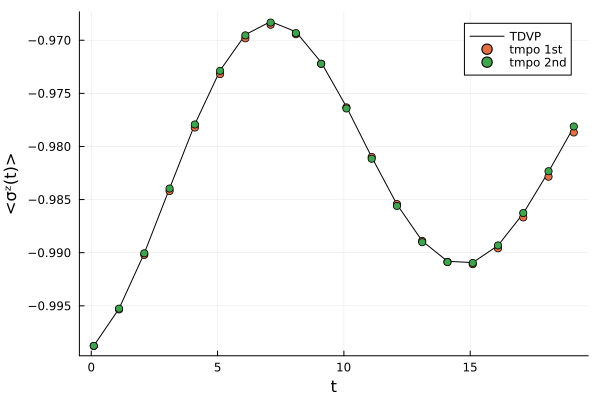

In [2]:
H₀ = transverse_field_ising(;J=1.0,g=0.0);

#Create a MPS with physical bond dimension d=2 and virtual D=50 and optimize it
Ψ = InfiniteMPS([2],[50]);
(gs,envs,_) = find_groundstate(Ψ,H₀,VUMPS(;verbose=false));

#Let's check some expectation values
sz_gs = expectation_value(gs,σᶻ()) # we have found the |↑↑...↑> or |↓↓...↓> state
E_gs  = expectation_value(gs,H₀,envs)

# time evolution Hamiltonian
Ht  = transverse_field_ising(;J=1.0,g=0.25);

dt = 0.1
Nsteps = 20
ts = dt .* 1:Nsteps

#Do the time evolution with tdvp
sz_tdvp = zeros(Nsteps);
let Ψt=gs,envs=environments(gs,Ht),alg=TDVP()
  for n in 1:Nsteps
    (Ψt,envs) = timestep(Ψt,Ht,dt,alg,envs);
    sz_tdvp[n] = real(expectation_value(Ψt,σᶻ())[1])
  end
end

# let's make a first order time evolution mpo out of Ht
Ht_mpo = make_time_mpo(Ht, dt, TaylorCluster{1}());

sz_tmpo = zeros(Nsteps);
let Ψt=gs
  for n in 1:Nsteps
    Ψt,_ = approximate(Ψt, (Ht_mpo, Ψt), VUMPS(; verbose=false));
    sz_tmpo[n] = real(expectation_value(Ψt,σᶻ())[1])
  end
end

# let's make a 2nd order time evolution mpo out of Ht
Ht_mpo = make_time_mpo(Ht, dt, TaylorCluster{2}());

sz_tmpo2 = zeros(Nsteps);
let Ψt=gs
  for n in 1:Nsteps
    Ψt,_ = approximate(Ψt, (Ht_mpo, Ψt), VUMPS(; verbose=false));
    sz_tmpo2[n] = real(expectation_value(Ψt,σᶻ())[1])
  end
end

# Compare the different methods
a = plot(xlabel="t",ylabel="<σᶻ(t)>");
plot!(a,ts,sz_tdvp,label="TDVP",c=:black);
scatter!(a,ts,sz_tmpo,label="tmpo 1st");
scatter!(a,ts,sz_tmpo2,label="tmpo 2nd")

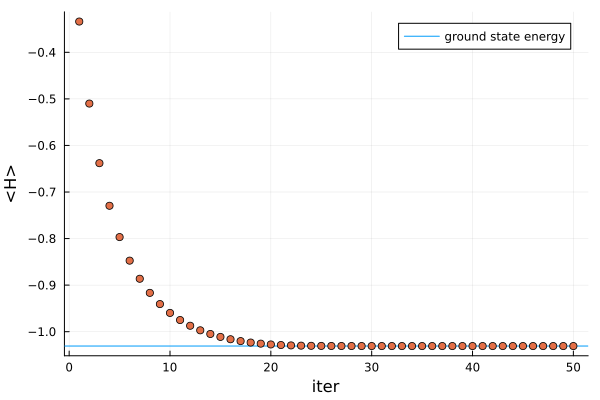

In [3]:
# We can also find the groundstate using imaginary time evolution
H    = transverse_field_ising(;J=1.0,g=0.35);

Ψ    = InfiniteMPS([2],[10]); #random MPS
Ψenv = environments(Ψ,H) ;
dt = 0.1;
Es = zeros(50);
Es[1] = real(expectation_value(Ψ,H,envs)[1]);
for n in 2:50
    (Ψ,Ψenv) = timestep(Ψ,H,-1im*dt,TDVP(),Ψenv)
    Es[n] = real(expectation_value(Ψ,H,Ψenv)[1])
end

b = plot(xlabel="iter",ylabel="<H>");
hline!([-1.030867019],label="ground state energy")
scatter!(b,Es,label="")